# Multi-Layer Perceptron Denoising with Synthetic Data

In this demo, we illustrate how to use the  multi-layer VAMP (ML-VAMP) method for denoising with a prior based on a multi-layer perceptron.  To describe the problem, consider the classical linear estimation of a vector $x$ from linear measurements,
$$
      y = Ax + w,  \quad w \sim {\mathcal N}(0,\tau_w I),
$$
where $w$ is AWGN noise.  The reconstruction of depends on our knowledge of $x$.  In Bayesian settings, this is formulated via a prior $p(x)$.  For example, in the [sparse linear inverse demo](../sparse/sparse_lin_inverse.ipynb), we specified a simple sparse prior.  Here, we will show how to use the `vampyre` package to describe a more complex prior via a multi-layer perceptron (MLP).

An MLP model is based on recursions of the form,
$$
    z_{2m+2} = \sigma(z_{2m+1}),\quad  z_{2m+1} = W_m z_{2m} + b_m,  \quad m=0,...,M-1,
$$
where, $M$ is the number of layers and, in each layer $m$, $W_m$ is a weight matrix, $b_m$ is a bias
term and $\sigma(\cdot)$ is an activation function.  In this demo, we will use the ReLU activation function
$\sigma(z) = \max(0,z)$.   The data is modeled as the final output of this recursion $x=z_{2M-1}$ and the initial conditions of the recursions $z_0$ have some prior $p(z_0)$.  The intermediate variables $z_0,\ldots,z_{2M-2}$ are called *hidden units*.  In this demo, we will build on the  [sparse probit demo](../sparse/sparse_probit.ipynb), to recover $x$ from $y$.  This demo will create a simple MLP model using randomly generated weights.  We will look at real data in the next demo.

## Importing the Package 
We first import the `vampyre` and other packages as in the [sparse linear inverse demo](sparse_lin_inverse.ipynb).

In [79]:
# Add the vampyre path to the system path
import os
import sys
vp_path = os.path.abspath('../../')
if not vp_path in sys.path:
    sys.path.append(vp_path)
import vampyre as vp

# Load the other packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Create a random MLP model and synthetic data

In this demo, we will create a simple MLP model with random weights.  We first set the dimensions and other parameters

In [80]:
# Dimensions
nin  = 20           # dimension of the latent variables, dim(z0)
nhid = [100,500]    # dimension of the hidden units in the subsequent layers, dim(z_1)=dim(z_2)=100, dim(z_3)=dim(z_4)=500,
nx = 784            # dimension of the unknown signal, dim(x)=dim(z_5)
ny = 300            # number of measurements = dimension(y)

# Other parameters
ns = 10             # Number of samples to generate
snr = 30            # SNR in dB

Next, we create a random matrices using the `randmlp` module which contains a `RandomMLP` class.  That class generates random weights and bias for given dimensions.  The weights and biases are selected to meet a certain sparsity target level at each layer, meaning a desired fraction of the hidden unit that are non-zero.  It is assumed that the hidden units, $h_0$, of the first layer are have $N(0,1)$ components.

In [81]:
import randmlp

# Sparsity target levels
sparse_tgt = [0.4,0.4]

# Generate a random network
mlp = randmlp.RandomMLP(nin,nhid,nout,sparse_tgt)
mlp.gen_weigths()

# Extract the weights and biases
Ws = mlp.Ws
bs = mlp.bs

Next, we generate random samples from the MLP.  When we run the `mlp` object it creates a list `zs=[z[0],...,z[2M+1]]`.

In [82]:
# Generate random samples
mlp.ns = ns
zs = mlp.run()

# Get the unknown vector x from the final layer of the MLP
x = zs[-1]

Finally, we create noisy version of the values from the final output layer.  Note that the SNR is measured on the signal after subtracting out the bias in the final layer.

In [70]:
# Get bias in final layer
nlayer = mlp.nlayers
bout = bs[nlayer]

# Generate a random sensing matrix 
A = np.random.normal(0,1,(ny,nout))

# Compute the noise variance.  For the noise variance we remove the bias
y0 = A.dot(zout-bout[:,None])
wvar = 10**(-0.1*snr)*np.mean(y0**2)

# Add noise
w = np.random.normal(0,np.sqrt(wvar),(ny,ns))
y = A.dot(x) + w

## Model the MLP and output as a multi-layer network

The MLP can be naturally modeled as a multi-layer network.  Recall that $z_0,\ldots,z_L$ represents the intermediate variables in the MLP with the final stage is the data $z_L=x$.  We can thus write the joint density of the measured data $y$ and hidden variables $z_0,\ldots,z_L$ as a product:
$$
    p(y,z_0,\ldots,z_L) = p(z_0)p(z_1|z_0)\cdots p(z_L|z_{L-1})p(y|z_L)
$$
To represent this in ML-VAMP, we create one estimator for each term on the right-hand side:
* $p(z_0)$ is a Gaussian prior on the latent variables represented in ML-VAMP via the `GaussEst` estimator;
* $p(z_{2m+1}|z_{2m})$ is the linear constraint $z_{2m+1}=W_m z_{2m} + b_m$ represened in ML-VAMP via the `LinEstimTwo` estimtor;
* $p(z_{2m+2}|z_{2m+1})$ is the ReLU constraint $z_{2m+1}=\max(0,z_{2m})$ represented in ML-VAMP via the `ReLUEstim` estimator
* $p(y|z_L)$ is the output estimator corresponding to the linear Gaussian observations $y=Az_L + w$ represented via the `LinEstim` estimator.  

In [71]:
# Create estimator list
est_list = []

# Initial estimator
est0 = vp.estim.GaussEst(0,1,zs[0].shape)
est_list.append(est0)

for i in range(mlp.nlayers):
    
    # Get shape
    zshape0 = zs[2*i].shape
    zshape1 = zs[2*i+1].shape
    
    # Add linear layer
    Wi = mlp.Ws[i]
    bi = mlp.bs[i]
    Wiop = vp.trans.MatrixLT(Wi,zshape0)
    esti = vp.estim.LinEstimTwo(Wiop,bi[:,None])
    est_list.append(esti)
    
    # Add the ReLU layer
    esti = vp.estim.ReLUEstim(zshape1)
    est_list.append(esti)
        
# Add the final linear layer with measurement
i = mlp.nlayers
zshape0 = zs[2*i].shape
Wi = mlp.Ws[i]
bi = mlp.bs[i]
Wiop = vp.trans.MatrixLT(A.dot(Wi),zshape0)
esti = vp.estim.LinEstim(Wiop,y-A.dot(bi[:,None]),wvar)
est_list.append(esti)


Next, we create the list of message handlers.

In [72]:
# Create the msg handlers
nvar = 2*mlp.nlayers+1
msg_hdl_list = []
damp = 0.7
for i in range(nvar):
    msg_hdl = vp.estim.MsgHdlSimp(shape=zs[i].shape,damp=damp)
    msg_hdl_list.append(msg_hdl)


## Run the ML-VAMP solver

We next create and run the ML-VAMP solver.  This is similar to the [sparse probit demo](../sparse/sparse_probit.ipynb).  

In [73]:
# Number of iterations 
nit = 50

# Create the MLVamp solver
solver = vp.solver.MLVamp(est_list,msg_hdl_list,comp_cost=True,\
        hist_list=['zhat','zhatvar'],nit=nit)
        
# Run the solver
solver.solve()

Extract the estimates in each iteration

In [74]:
# Extract the estimate
zhatvar = solver.hist_dict['zhatvar']
zhat = solver.hist_dict['zhat']

## Measure the error per iteration

We will measure the mean squared error as a function of the iteration.  As in the  [sparse probit demo](../sparse/sparse_probit.ipynb), we will measure the Debiased-MSE as computed with the following method.

In [75]:
def debias_mse(zhat,ztrue):
    tol = 1e-8
    zcorr = np.abs(np.mean(zhat.conj()*ztrue,axis=0))**2
    zpow = np.mean(ztrue.conj()*ztrue,axis=0)
    zhatpow = np.mean(zhat.conj()*zhat,axis=0)
    if np.any(zpow < tol) or np.any(zhatpow < tol):
        dmse = 0
    else:
        rho = 1-zcorr/zpow/zhatpow
        dmse = 10*np.log10(np.mean(rho))
    return dmse

The debiased MSE is then compared to the predicted value from ML-VAMP.  We see that we obtain a very accurate estimate and the predicted and actual MSE match well for each stage.

In [76]:
# Compute the powers
zpow = np.zeros(nvar)
for i in range(nvar):
    zpow[i] = np.mean(zs[i]**2)
    
nit2 = len(zhat)
mse_act = np.zeros((nit2,nvar))
mse_pred = np.zeros((nit2,nvar))
for it in range(nit2):
    for i in range(nvar):
        zhati = zhat[it][i]
        zerr = np.mean(np.abs(zhati - zs[i])**2)
        mse_act[it,i] = debias_mse(zhati,zs[i])        
        mse_pred[it,i] = 10*np.log10(np.mean(zhatvar[it][i])/zpow[i])        
        
mse_actf = mse_act[-1,:]
mse_predf = mse_pred[-1,:]
print("stage   MSE-actual   MSE-pred")
for i in range(nvar):
    print("{0:d}      {1:7.2f}      {2:7.2f}".format(i,mse_actf[i],mse_predf[i]))

stage   MSE-actual   MSE-pred
0       -34.93       -35.04
1       -36.65       -36.87
2       -37.98       -39.10
3       -37.88       -38.45
4       -36.86       -37.99


We can also plot the results per iteration.

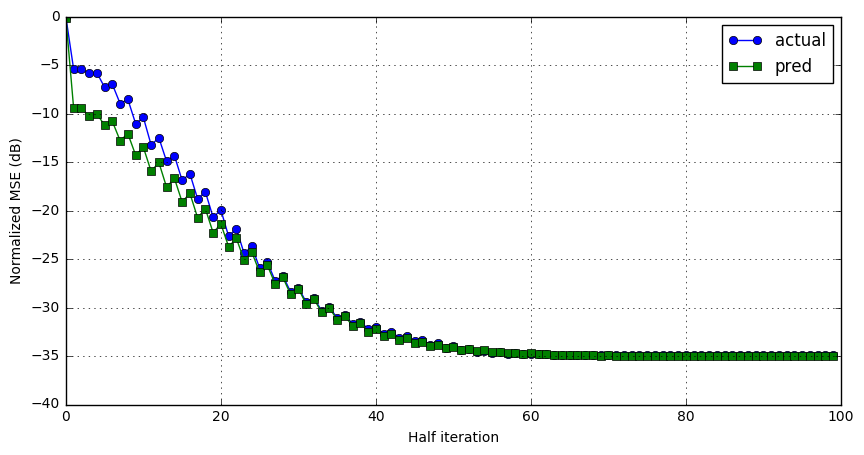

In [84]:
t = np.array(range(nit2))
plt.figure(figsize=(10,5))
i = 0
plt.plot(t, mse_act[:,i],'-o')
plt.plot(t, mse_pred[:,i],'-s')
plt.legend(['actual', 'pred'])
plt.grid()
plt.xlabel('Half iteration')
plt.ylabel('Normalized MSE (dB)')